In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

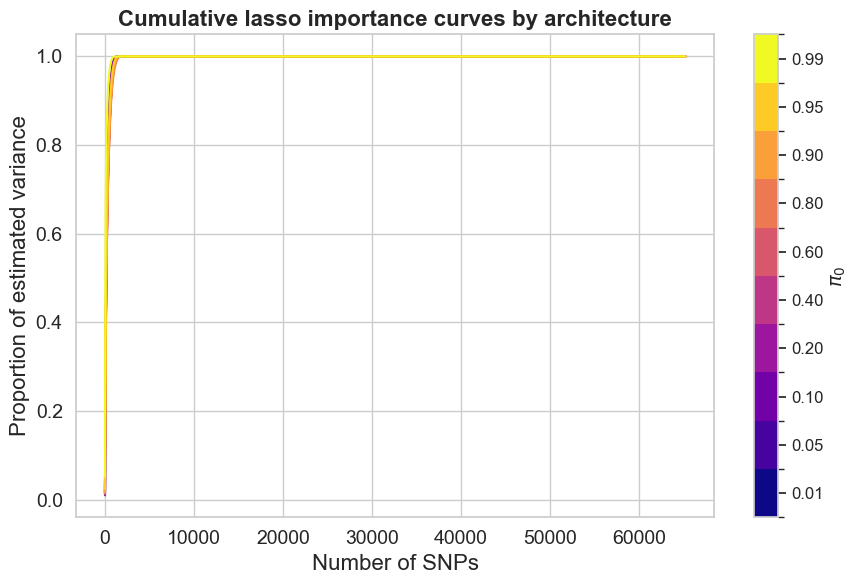

In [2]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Full set of possible architectures and pi_0 values
all_archs = list(range(1, 11))
pi_0_values_all = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

# Base path for lasso coefficient files
base_path = "C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/Lasso"

# Identify available architecture files dynamically
available_archs = []
for arch in all_archs:
    file_path = os.path.join(base_path, f"lasso_coefs_arch{arch}.csv")
    if os.path.isfile(file_path):
        available_archs.append(arch)

# Filter pi_0 values based on available architectures
pi_0_values = [pi_0_values_all[arch - 1] for arch in available_archs]

# Load genotype data once
data = pd.read_feather("c:/Users/gard_/Documents/MasterThesis/Code/Data/SNP1_70k.feather")
X_full = data.drop("ringnr", axis=1).fillna(0).astype('int64')

# Setup plot
fig, ax = plt.subplots(figsize=(9, 6))

# Create discrete plasma colormap for the number of available architectures
colors = cm.plasma(np.linspace(0, 1, len(available_archs)))
cmap = mcolors.ListedColormap(colors)
bounds = np.linspace(0.5, len(available_archs) + 0.5, len(available_archs) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Loop over available architectures
for idx, arch in enumerate(available_archs):
    coef_path = os.path.join(base_path, f"lasso_coefs_arch{arch}.csv")
    coef_df = pd.read_csv(coef_path)

    # Align SNPs
    coef_df = coef_df[coef_df['SNP'].isin(X_full.columns)].copy()
    X = X_full[coef_df['SNP'].values]  # re-order X to match coef_df
    assert all(coef_df['SNP'].values == X.columns.values), f"SNPs not aligned for arch {arch}"

    # Compute variance-based importance
    var_X = X.var(axis=0).values
    var_term = (coef_df['beta_L'].values ** 2) * var_X
    var_term = -np.sort(-var_term) / np.sum(var_term)
    cumulative_importance = np.cumsum(var_term)

    # Plot curve with colormap
    x = np.arange(len(cumulative_importance))
    ax.plot(x, cumulative_importance, color=cmap(idx), label=f"$\\pi_0$ = {pi_0_values[idx]:.2f}")

# Labels and title
ax.set_title("Cumulative lasso importance curves by architecture", fontsize=16, weight="bold")
ax.set_xlabel("Number of SNPs", fontsize=16)
ax.set_ylabel("Proportion of estimated variance", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# Discrete colorbar for π₀
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ticks=range(1, len(available_archs) + 1), ax=ax)
cbar.ax.set_yticklabels([f"{p:.2f}" for p in pi_0_values])
cbar.set_label(r'$\pi_0$', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Finalize and save
plt.tight_layout()
plt.savefig("C:/Users/gard_/Documents/MasterThesis/Code/Figures/CFI_lasso_sim.pdf", dpi=300, bbox_inches="tight")
plt.show()